**GMM second labaratory work.**<br>
Klasės - banana, bee, jellyfish

**Setting up the environment**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import models
import time
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import metrics
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [ ]:
!pip3 install -r /content/OIDv4_ToolKit/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.3 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
!python /content/OIDv4_ToolKit/main.py downloader --classes Banana Bee Jellyfish --type_csv all --limit 200


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading Banana.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Do you want to download the missing file? [Y/n] y
...145%, 0 MB, 47695 KB/s, 0 seconds passed
[DOWNLOAD] | File c

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Model training**

In [ ]:
#Transform function for normalizing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
#Setting up model for training # pabandyti paimti vgg modely
class RasNet50ConvNet3(nn.Module):

    def __init__(self):
        super().__init__()

        # convolutional layers (extracts increasingly complex features from input images)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), stride=2, padding=1)
        #Batch Normalization improves train speed and stability
        #Batch normalization involves normalizing the activations of each layer by subtracting the batch mean and dividing by the batch standard deviation
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # skip connections to get information faster from one layer to another
        self.skip1 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 1), stride=2)
        self.skip2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), stride=2)

        # connected layers
        self.fc1 = nn.Linear(in_features=64 * 36, out_features=500) # adjust the input size
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=3) #final output

        # dropout layer preventing overfitting
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, X):
        
        # convolutional layers
        X = F.relu(self.bn1(self.conv1(X)))
        X_skip1 = self.skip1(X)
        X = F.max_pool2d(X, 2)

        X = F.relu(self.bn2(self.conv2(X)))
        X_skip2 = self.skip2(X)
        X = F.max_pool2d(X, 2)

        X = F.relu(self.bn3(self.conv3(X)))
        if X_skip2.shape[-1] != X.shape[-1]:
            diff = X.shape[-1] - X_skip2.shape[-1]
            X_skip2 = F.pad(X_skip2, (0, diff, 0, diff))
        X = X + X_skip2 # skip connection
        #Max pool to reduce spatial size of feature maps
        X = F.max_pool2d(X, 2)

        # flattento 1D vector
        X = X.view(X.shape[0], -1)

        # connected layers
        X = F.relu(self.fc1(X))
        X = self.dropout(X)

        X = F.relu(self.fc2(X))
        X = self.dropout(X)

        X = self.fc3(X)

        return X

In [ ]:
#Getting the paths of images and their labels
def get_paths(files_path):
  data = []

  classes = ['Banana', 'Bee', 'Jellyfish']

  for class_name in classes:
      image_dir = os.path.join(files_path, class_name)
      label_dir = os.path.join(image_dir, 'Label')
    
      for image_file in os.listdir(image_dir):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))
            data.append((image_path, label_path, class_name))
  return data

In [ ]:
#Paths to the files
train_paths = 'OID/Dataset/train';
test_paths = 'OID/Dataset/test';
#Calling get_paths 
train_data = get_paths(train_paths);
test_data = get_paths(test_paths);

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, num_classes=3):
        self.data = data
        self.transform = transform
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
      data_point = self.data[i]
      image_path = data_point[0]
      #Assigning the labels
      with open(data_point[1]) as file:
          label = file.readline().split(" ")[0]
      if 'Banana' in label:
          label = 0
      elif 'Bee' in label:
          label = 1
      else:
          label = 2
      label_onehot = torch.zeros(self.num_classes)
      label_onehot[label] = 1
      image = Image.open(image_path).convert("RGB")
      #Applying the transformations if any are set
      if self.transform is not None:
          image = self.transform(image)
      return image, label_onehot

In [ ]:
#Additional train transformation for image augmentation 
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CustomDataset(train_data, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
dataset = datasets.ImageFolder(root="/content/OID/Dataset/train", transform=train_transforms)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
len(dataset)

600

In [ ]:
augmented_dataset = CustomDataset(train_data, transform=train_transforms)

augmented_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

combined_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset]) #Panaikinti ir daugiau nuotrauku parsisiusti

combined_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=1, shuffle=True)

In [ ]:
# Create instance of the model
model = RasNet50ConvNet3()

losses = []
epoch_accuracies = []
epoches = 20
start = time.time()
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Model Training...
for epoch in range(epoches):

    epoch_loss = 0.0
    epoch_accuracy = 0

    for inputs, labels in augmented_dataloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        predicted_labels = (torch.sigmoid(preds) > 0.5).float()
        accuracy = ((predicted_labels == labels).float().mean()) 
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(augmented_dataloader)  
    epoch_accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(augmented_dataloader) 
    losses.append(epoch_loss)
    print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy * 100, time.time() - start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 --- Epoch: 0, train loss: 0.6814, train acc: 62.4443, time: 34.36243462562561
................................................................................................................................................................................................................................................................................................................................

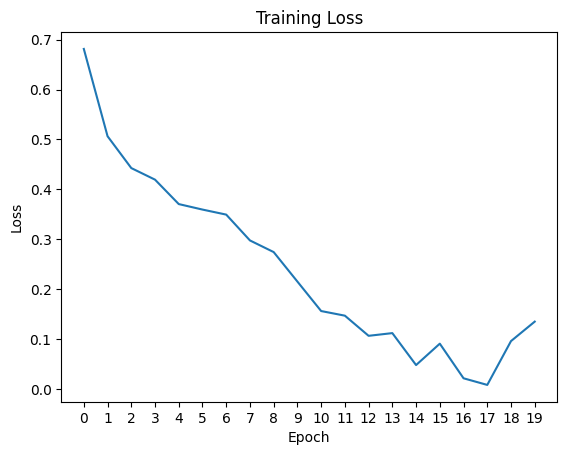

In [ ]:
plt.plot([l.detach().numpy() for l in losses])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.xticks(range(0, epoches, 1))

plt.show()

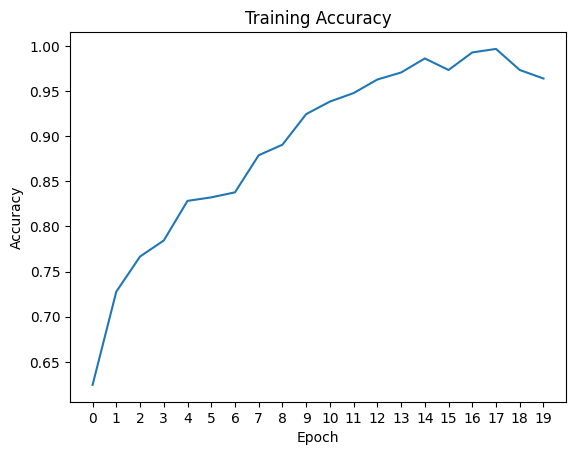

In [ ]:
plt.plot(epoch_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(range(0, epoches, 1))
plt.show()

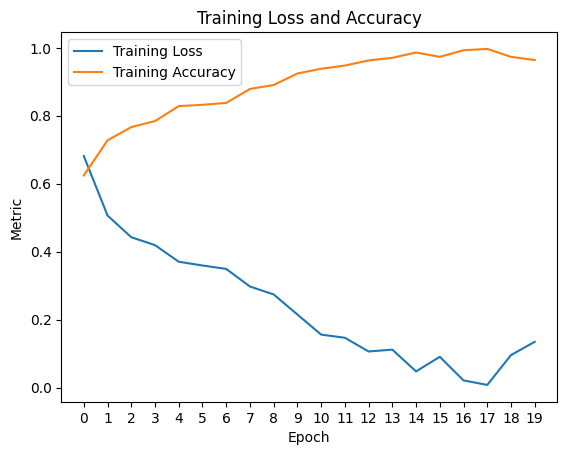

In [ ]:
plt.plot([l.detach().numpy() for l in losses], label='Training Loss')
plt.plot(epoch_accuracies, label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.xticks(range(0, epoches, 1))
plt.show()

**Model testing**

In [ ]:
test_dataset = CustomDataset(test_data, transform=transform)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
#Treshold [0:1]
threshold = [0.20, 0.30, 0.40, 0.50, 0.60]
#Initializing metrics for statistic calculation
true_possitive = [0,0,0,0,0]
false_possitive = [0,0,0,0,0]
true_negative = [0,0,0,0,0]
false_negative = [0,0,0,0,0]
classesIndexes = [0, 1, 2]
decoder = {
    0: "Banana",
    1: "Bee", 
    2: "Jellyfish"
}

actual_list = []
predict_list = []
#Loading data from dataloader
for data in test_dataloader:
  inputs, labels = data
  labelId = 0
  p = 0;
  for l in labels[0]:
    if(l == 1):
      labelId = p
      break;
    p+=1 
  class_probs_batch = []
  #Getting model predictions  
  with torch.no_grad():
    output = model(inputs)
    probs = output.sigmoid()
  #Picking out predictions from batch 
  for i in range(probs.shape[0]):
    #Picking only predictions from selected classes
    class_probs_item = [probs[i, j] for j in classesIndexes] 
    class_probs_batch.append(class_probs_item)
  top_probs, top_indices = torch.topk(probs[i], k=1)
  predict_label = decoder[int(top_indices)]
  predict_list.append(predict_label)
  actual = decoder[labelId]
  actual_list.append(actual)

  #Iteration for Label id from batch
  x = 0
  for cpb in class_probs_batch:
    #Iteration for Class id from selected classes
    j = 0
    for cp in cpb:
      #Iteration for threshold measurments 
      i = 0
      for th in threshold:
        #A positive instance that is correctly classified as positive by the model
        if (classesIndexes[j] == labelId) and  (cp > th): 
            true_possitive[i] += 1
        #A negative instance that is incorrectly classified as positive by the model.
        elif (classesIndexes[j] == labelId) and (cp < th):
            false_negative[i] += 1
        #A positive instance that is incorrectly classified as negative by the model.
        elif (classesIndexes[j] != labelId) and (cp > th):
            false_possitive[i] += 1
        #A negative instance that is correctly classified as negative by the model.
        elif (classesIndexes[j] != labelId) and (cp < th):
            true_negative[i] += 1
        i+=1
      j+=1
    x+=1 

In [ ]:
print(actual_list)

['Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee', 'Bee

In [ ]:
print(predict_list)

['Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Jellyfish', 'Banana', 'Banana', 'Jellyfish', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Banana', 'Jellyfish', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Bee', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Banana', 'Bee', 'Bee', 'Banana', 'Bee', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Banana', 'Bee', 'Bee', 'Bee', 'Bee', 'Banana', 'Bee', 'Banana', 'Banana

In [ ]:
i = 0
while(i<5):
  print(f"tp: {true_possitive[i]}")
  print(f"fp: {false_possitive[i]}")
  print(f"tn: {true_negative[i]}")
  print(f"fn: {false_negative[i]}")
  print()
  i+=1

tp: 251
fp: 157
tn: 585
fn: 120

tp: 244
fp: 152
tn: 590
fn: 127

tp: 241
fp: 142
tn: 600
fn: 130

tp: 234
fp: 138
tn: 604
fn: 137

tp: 228
fp: 132
tn: 610
fn: 143



In [ ]:
precisions = []
recalls = []
accuracies = []
f1_scores = []



i = 0
for th in threshold:
  #Precision measures how many of the predicted positive labels are actually true positives
  precision = true_possitive[i] / (true_possitive[i] + false_possitive[i])
  #Recall measures how many of the actual positive labels are correctly identified
  recall = true_possitive[i] / (true_possitive[i] + false_negative[i])
  #Accuracy measures how well the model correctly predicts both positive and negative labels
  accuracy = (true_possitive[i] + true_negative[i]) / (true_possitive[i] + true_negative[i] + false_possitive[i] + false_negative[i]);
  #The F1 statistic is a measure of a model's accuracy, specifically in terms of its precision and recall.
  f1 = 2 * (precision * recall) / (precision + recall)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1: {f1}\n")

  precisions.append(precision)
  recalls.append(recall)
  accuracies.append(accuracy)
  f1_scores.append(f1)


  i+=1

Accuracy: 0.7511230907457322
Precision: 0.6151960784313726
Recall: 0.6765498652291105
F1: 0.6444159178433889

Accuracy: 0.7493261455525606
Precision: 0.6161616161616161
Recall: 0.6576819407008087
F1: 0.636245110821382

Accuracy: 0.7556154537286612
Precision: 0.6292428198433421
Recall: 0.6495956873315364
F1: 0.6392572944297082

Accuracy: 0.7529200359389039
Precision: 0.6290322580645161
Recall: 0.6307277628032345
F1: 0.629878869448183

Accuracy: 0.7529200359389039
Precision: 0.6333333333333333
Recall: 0.6145552560646901
F1: 0.6238030095759234



**Diagrams**

Presicion

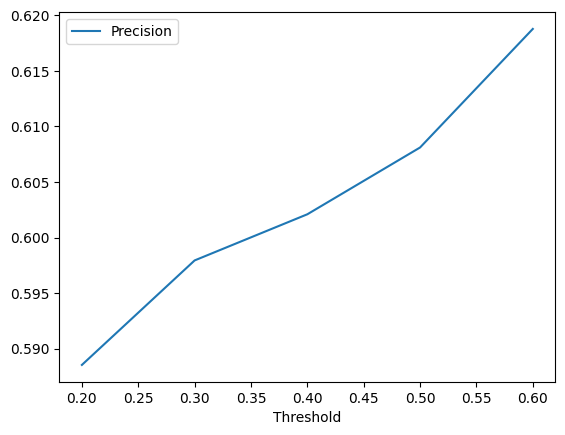

In [ ]:
plt.plot(threshold, precisions, label='Precision')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Recal

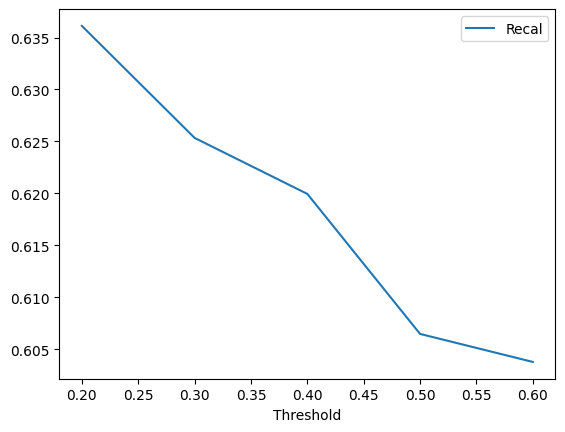

In [ ]:
plt.plot(threshold, recalls, label='Recal')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Accuracy

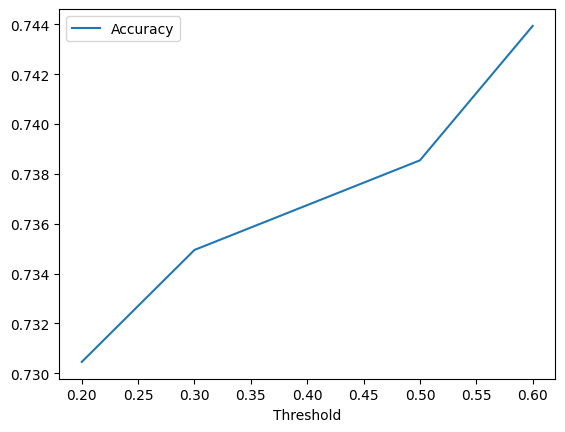

In [ ]:
plt.plot(threshold, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.legend()
plt.show()

F1

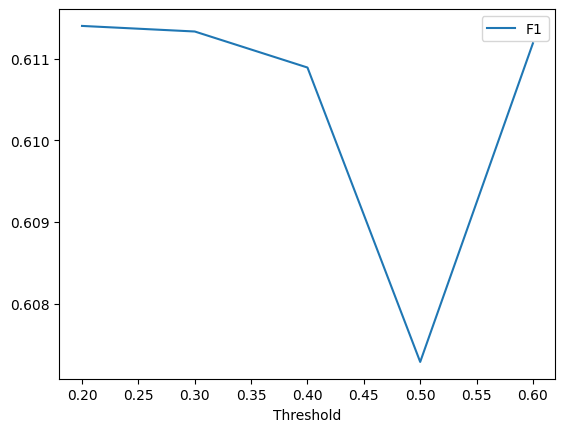

In [ ]:
plt.plot(threshold, f1_scores, label='F1')
plt.xlabel('Threshold')
plt.legend()
plt.show()

Confusion matrix

In [ ]:
confusion_matrix = PrettyTable()
confusion_matrix.field_names = ["True Positive", "False Positive", "True Negative", "False Negative"]
for i in range(5):
    confusion_matrix.add_row([true_possitive[i], false_possitive[i], true_negative[i], false_negative[i]])
print(confusion_matrix)

+---------------+----------------+---------------+----------------+
| True Positive | False Positive | True Negative | False Negative |
+---------------+----------------+---------------+----------------+
|      236      |      165       |      577      |      135       |
|      232      |      156       |      586      |      139       |
|      230      |      152       |      590      |      141       |
|      225      |      145       |      597      |      146       |
|      224      |      138       |      604      |      147       |
+---------------+----------------+---------------+----------------+


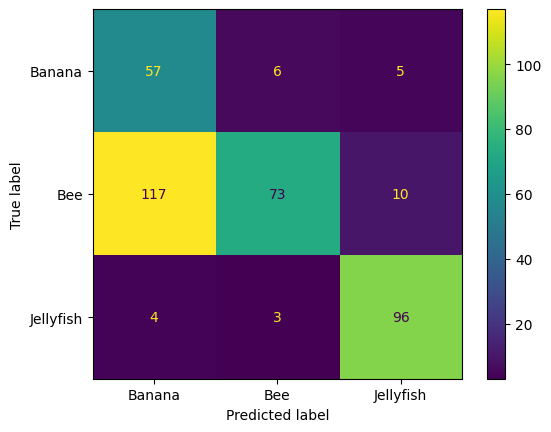

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual_list, predict_list)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Banana", "Bee", "Jellyfish"])

cm_display.plot()
plt.show() 